## Setup


In [1]:
import json
import wandb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import torch
from huggingface_hub import login
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import Trainer, TrainingArguments

sns.set()
%matplotlib inline

In [2]:
sns.set_style("whitegrid", {"axes.grid": False})

In [3]:
# project name for wandb.ai
project_name = "Arabic-Weakly-Supervised-Propaganda-Detection"
run_name = "weighted-cross-entropy"

# defining data paths
labeled_data_path = "../data/processed/to_label.json"
lf_dev_data_path = "../data/processed/lf_dev.json"
test_data_path = "../data/processed/test_data.json"
access_tokens_path = "../data/access_tokens.json"

# defining model names
seed = 42
model_ckpt = "UBC-NLP/MARBERT"
model_name = "marbert-weakly-finetuned-arabic-propaganda"
model_path = f"../models/{model_name}"

In [4]:
with open(access_tokens_path) as f:
    access_tokens = json.load(f)

In [5]:
login(access_tokens["huggingface"]["write_token"])

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to C:\Users\ehhho\.cache\huggingface\token
Login successful


## Data Preprocessing


In [6]:
data = pd.read_json(labeled_data_path)
data.head(2)

,tweetid,tweet_text,text,tech,label
0,295735762505322497,النعيم أمي، وعين أمي، وقبلة أمي، فأكرمها يالله...,النعيم أمي، وعين أمي، وقبلة أمي، فأكرمها يالله...,None,0
1,1080873494227886086,RT @rood516: عرض الاجازه😍👌🏻1\nســــاعه\nقـــلم...,RT : عرض الاجازه1 ســــاعه قـــلم كــبك نظـــا...,None,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2100 entries, 0 to 2099
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetid     2100 non-null   int64 
 1   tweet_text  2100 non-null   object
 2   text        2100 non-null   object
 3   tech        202 non-null    object
 4   label       2100 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 98.4+ KB


In [8]:
# getting class weights
w = data.label.value_counts(normalize=True).to_numpy()
w

array([0.90380952, 0.09619048])

In [9]:
# splitting the data to 60-20-20 % portions
train, valid = train_test_split(
    data, train_size=0.6, stratify=data.label, random_state=seed
)
valid, test = train_test_split(
    valid, train_size=0.5, stratify=valid.label, random_state=seed
)

In [10]:
# generating the labeling functions development dataset
lf_dev, _ = train_test_split(
    train, train_size=500, stratify=train.label, random_state=seed
)

In [11]:
len(train), len(valid), len(test), len(lf_dev)

(1260, 420, 420, 500)

In [12]:
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)


lf_dev = lf_dev.reset_index(drop=True)
lf_dev.to_json(lf_dev_data_path)
test.to_json(test_data_path)

## Tokenization


In [13]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [14]:
# transformimg from pandas to hugging face datasets

train = Dataset.from_pandas(train, split="train")
valid = Dataset.from_pandas(valid, split="valid")
test = Dataset.from_pandas(test, split="test")

ds = DatasetDict({"train": train, "validation": valid, "test": test})
ds

DatasetDict({
    train: Dataset({
        features: ['tweetid', 'tweet_text', 'text', 'tech', 'label'],
        num_rows: 1260
    })
    validation: Dataset({
        features: ['tweetid', 'tweet_text', 'text', 'tech', 'label'],
        num_rows: 420
    })
    test: Dataset({
        features: ['tweetid', 'tweet_text', 'text', 'tech', 'label'],
        num_rows: 420
    })
})

In [15]:
def tokenize_ds(field):
    return tokenizer(field["text"], truncation=True)

In [16]:
cols = ds["train"].column_names.copy()
cols.remove("label")
cols

['tweetid', 'tweet_text', 'text', 'tech']

In [17]:
ds_encoded = ds.map(tokenize_ds, batched=True, remove_columns=cols)
ds_encoded

Map:   0%|          | 0/1260 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/420 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1260
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 420
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 420
    })
})

## Modeling


### Setup


In [18]:
def compute_scores(preds):
    logits, labels = preds
    pred = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred)
    prec = precision_score(labels, pred)
    rec = recall_score(labels, pred)
    return {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}

In [19]:
label_names = ["Transparent", "Propaganda"]
id2label = {i: l for i, l in enumerate(label_names)}
label2id = {l: i for i, l in enumerate(label_names)}

In [20]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=len(label_names),
    id2label=id2label,
    label2id=label2id,
    token=access_tokens["huggingface"]["read_token"],
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
training_args = TrainingArguments(
    output_dir=model_path,
    overwrite_output_dir=True,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=1e-4,
    warmup_ratio=0.1,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    log_level="error",
    logging_steps=1,
    load_best_model_at_end=True,
)

### Training


In [22]:
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    if torch.cuda.device_count() > 1:
        device = torch.device("cuda:0")
    else:
        device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [23]:
# inverting the weights for the weighted loss
w = 1 / w
w = w / w.sum()
w = torch.tensor(w, device=device, dtype=torch.float32)

In [24]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")  # [batch_size, num_labels]
        outputs = model(**inputs)
        logits = outputs.get("logits")  # [batch_size, num_labels]
        loss_fct = torch.nn.CrossEntropyLoss(weight=w)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [25]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [26]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=ds_encoded["train"],
    eval_dataset=ds_encoded["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_scores,
)

In [27]:
wandb.login(key=access_tokens["wandb"]["login"])

wandb: Currently logged in as: bateekalmutairi. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\ehhho/.netrc


True

In [28]:
wandb.init(project=project_name, name=f"{model_name}-{run_name}")

In [29]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.185400,0.429022,0.921429,0.595238,0.609756,0.602410
2,0.047000,0.426350,0.919048,0.566038,0.731707,0.638298
3,0.056000,0.812524,0.928571,0.641026,0.609756,0.625000
4,0.006000,0.891268,0.926190,0.619048,0.634146,0.626506
5,0.003500,1.012486,0.928571,0.648649,0.585366,0.615385


TrainOutput(global_step=200, training_loss=0.23406039673835038, metrics={'train_runtime': 453.9619, 'train_samples_per_second': 13.878, 'train_steps_per_second': 0.441, 'total_flos': 142587692009040.0, 'train_loss': 0.23406039673835038, 'epoch': 5.0})

In [30]:
trainer.evaluate(ds_encoded["test"], metric_key_prefix="test")

{'test_loss': 0.24022212624549866,
 'test_Accuracy': 0.9261904761904762,
 'test_Precision': 0.5737704918032787,
 'test_Recall': 0.875,
 'test_F1': 0.693069306930693,
 'test_runtime': 1.1186,
 'test_samples_per_second': 375.472,
 'test_steps_per_second': 12.516,
 'epoch': 5.0}

In [31]:
test_outs = trainer.predict(ds_encoded["test"])
preds = np.argmax(test_outs[0], axis=-1)
labels = test_outs[1]

In [32]:
print(classification_report(labels, preds, target_names=label_names))

              precision    recall  f1-score   support

 Transparent       0.99      0.93      0.96       380
  Propaganda       0.57      0.88      0.69        40

    accuracy                           0.93       420
   macro avg       0.78      0.90      0.83       420
weighted avg       0.95      0.93      0.93       420



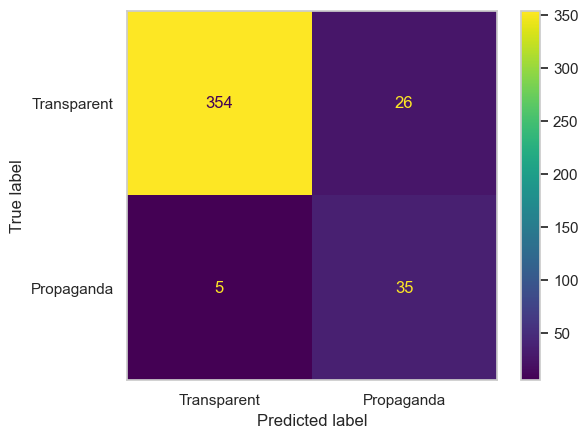

In [33]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)


disp.plot()
plt.show()

In [34]:
trainer.save_model(model_path)

In [35]:
trainer.push_to_hub()

pytorch_model.bin:   0%|          | 0.00/651M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

'https://huggingface.co/Bmalmotairy/marbert-weakly-finetuned-arabic-propaganda/tree/main/'

In [36]:
wandb.finish()

eval/Accuracy,▃▁█▆█
eval/F1,▁█▅▆▄
eval/Precision,▃▁▇▅█
eval/Recall,▂█▂▃▁
eval/loss,▁▁▆▇█
eval/runtime,▆█▁▄▂
eval/samples_per_second,▃▁█▅▇
eval/steps_per_second,▃▁█▅▇
test/Accuracy,▁
test/F1,▁
test/Precision,▁
